In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)
from IPython.display import display, IFrame, HTML, YouTubeVideo

def show_permutation_testing_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vSovXDonR6EmjrT45h4pY1mwmcKFMWVSdgpbKHC5HNTm9sbG7dojvvCDEQCjuk2dk1oA4gmwMogr8ZL/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 569
    display(IFrame(src, width, height))

# Lecture 17 – Permutation Testing

## DSC 10, Summer 2022

### Announcements

- Lab 5 is due **tomorrow at 11:59pm**.
- Homework 5 is due **Sat 8/13 at 11:59pm**.

### Agenda

- TVDs and test statistics.
- A new type of hypothesis test.
    - So far, we've been assessing models given a single random sample.
        - We flip a coin 400 times. Are the flips consistent with the coin being fair?
        - Did the jury panel in the Swain case look like a random sample from the eligible population?
        - Are the test scores for the TA's section a random sample from the class's scores?
    - But we often have **two** random samples we wish to compare.
        - Example: birth weights of babies born to smoking mothers vs. non-smoking mothers 👶.
        - Example: drops in pressure for footballs from two different teams (Deflategate) 🏈.
    - **Permutation testing** (i.e. **A/B testing**) will help us decide whether two random samples come from the same distribution.

## TVD and Test Statistics

In [2]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


In [3]:
def total_variation_distance(dist1, dist2):
    '''Computes the TVD between two categorical distributions, 
       assuming the categories appear in the same order.'''
    return np.abs((dist1 - dist2)).sum() / 2

In [4]:
# Calculate the TVD between the distribution of ethnicities in the eligible population
# and the distribution of ethnicities in the observed panelists

total_variation_distance(jury.get('Eligible'), jury.get('Panels'))

0.14

### You Try: Jury Panels using TVD

1. Draw a random jury panel of 1453 people from the population. Calculate the TVD between the sample and population.
1. Repeat 10,000 times, store results in an array called `tvds`.
1. Plot the `tvds` in a histogram, and plot the observed TVD (0.14) as a vertical line.
1. Calculate the p-value for this hypothesis test, and draw a conclusion.

In [5]:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453 
sample_distribution

array([0.15, 0.19, 0.12, 0.54, 0.01])

In [6]:
panels_and_sample = jury.assign(RandomSample=sample_distribution) 
panels_and_sample

,Ethnicity,Eligible,Panels,RandomSample
0,Asian,0.15,0.26,1.47e-01
1,Black,0.18,0.08,1.88e-01
2,Latino,0.12,0.08,1.20e-01
3,White,0.54,0.54,5.38e-01
4,Other,0.01,0.04,7.57e-03


In [7]:
total_variation_distance(panels_and_sample.get('RandomSample'), eligible)

0.007887130075705417

In [8]:
tvds = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

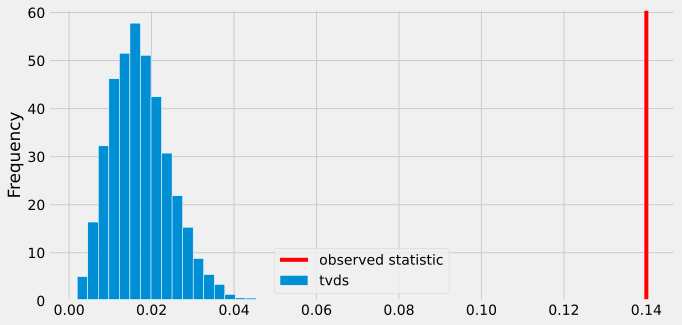

In [9]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(tvds=tvds).plot(kind='hist', density=True, bins=20, ec='w', figsize=(10, 5))
plt.axvline(observed_tvd, color='red', label='observed statistic')
plt.legend();

In [10]:
# p-value
np.mean(tvds >= observed_tvd)

0.0

When the p-value is tiny, Python rounds to 0.

## Hypothesis Test Toolbox

1. State: null and alternative hypotheses.
1. Pick test statistic: use alternative hypothesis to decide what test statistic to use.
    1. Mean (flight delays)
    1. Count (# Black people in jury)
    1. Absolute difference in proportions (pea plants)
    1. TVD (Alameda juries)
1. Simulate: draw samples under the null hypothesis, calculate the test statistic on each one.
    1. Know population? `df.sample(n)`.
    1. Know proportions in population? `np.random.multinomial(n, props)`.
    1. Today: permutation testing.
1. Visualize: plot the simulated values and observed test statistic.
1. Find p-value: proportion of simulations that have values at least as extreme as the one observed.

## Motivating A/B testing

### 2008 Obama Campaign

<center><img src='data/obama.png' width=600></center>

- In 2008, the Obama campaign tested several different versions of a pop-up box on their website. Each visitor to the site would view a random version of the site, with different buttons and images.
- For each version, they recorded the number of people who signed up to be a donor.
- Read more at [this blog post](https://blog.optimizely.com/2010/11/29/how-obama-raised-60-million-by-running-a-simple-experiment/).

### Button choices

- Here are the four different buttons they used.
- Intuitively, which one do you think would lead to the most signups?

<center><img src='data/buttons.png' width=400>

### The winner

<center><img src='data/winner.png' width=600>

It is estimated that this combination of image and button brought in an **additional 60 million dollars** in donations versus the original version of the site.

## Example: Smoking and birth weight 👶

### Smoking and birth weight

- **Question:** Is there a significant difference in the weight of babies born to mothers who smoked vs. babies born to mothers who didn't smoke?
- We'll load in data from an **observational study**.
    - Each row corresponds to a baby.
    - There are two groups of babies: those whose mothers smoked, and those whose mothers didn't smoke.

In [11]:
baby = bpd.read_csv('data/baby.csv')
baby

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
...,...,...,...,...,...,...
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False
1173,117,297,38,65,129,False


In [12]:
# Selecting only the columns that are relevant
smoking_and_birthweight = baby.get(['Maternal Smoker', 'Birth Weight'])
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
...,...,...
1171,True,130
1172,False,125
1173,False,117


### Visualizing the distribution of each group

In [13]:
smokers = smoking_and_birthweight[smoking_and_birthweight.get('Maternal Smoker')]
non_smokers = smoking_and_birthweight[-smoking_and_birthweight.get('Maternal Smoker')]

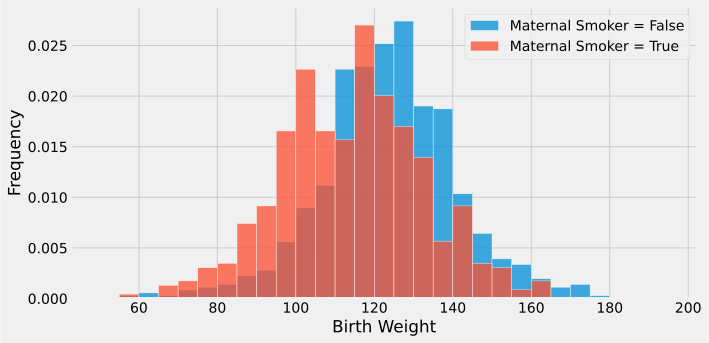

In [14]:
fig, ax = plt.subplots()
baby_bins = np.arange(50, 200, 5)
non_smokers.plot(kind='hist', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w', figsize=(10, 5))
smokers.plot(kind='hist', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w')
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight');

### The question

- It appears that babies born to smokers typically have lower birth weights than babies born to non-smokers.
- Does the difference we see reflect a real difference in the population?
- Or is it just due to random chance?

### Testing hypotheses

- **Null hypothesis**: In the population, birth weights of babies born to smokers and non-smokers have the same distribution.
    - In other words, the difference we saw was to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers have lower birth weights than babies born to non-smokers, on average.
    - In other words, what we saw cannot be explained by random chance alone, and there is instead a meaningful difference in these distributions.

### You Try:

- Come up with **three** different test statistics that compare birth weights.
- For each test statistic, decide:
    1. Is it valid to use with our null + alternative hyp?
    2. Which values of the statistic favor alternative? Large? Or small?

### Test statistic: the difference between means

The test statistic we'll use is

$$\text{mean birth weight of babies born to non-smokers} - \text{mean birth weight of babies born to smokers}$$

Note that **large values of this test statistic favor the alternative hypothesis**.

In [15]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.09
True,113.82


In [16]:
# The difference between the mean birth weight for non-smokers and smokers
means = means_table.get('Birth Weight')
observed_difference = means.loc[False] - means.loc[True]
observed_difference

9.266142572024918

### Hypothesis testing through simulation

- **Null hypothesis**: The two groups are sampled from the same distribution.
- **Test statistic**: The difference between the mean non-smoker weight and the mean smoker weight.
- Note that the null hypothesis doesn't say *what* the distribution is.
    - This is different from earlier examples (jury panels, fair coins, etc.) where we specified exactly what the distribution under the null is.
    - We can't draw directly from the distribution!
- We have to do something a bit more clever.

### Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same population distribution.
- If that's true, then whether `'Maternal Smoker'` is `True` or `False` should have no impact on the `'Birth Weight'` variable.
- **Idea:** the distribution of birth weights for smokers and non-smokers should remain the same if we shuffle one of the two columns in our DataFrame.

In [17]:
# What if we shuffle one of these columns?
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
...,...,...
1171,True,130
1172,False,125
1173,False,117


### Permutation tests

- Perhaps the difference in means we saw is due to random chance in assignment.
- **The key idea behind permutation tests**: Shuffle the group labels (i.e. `True`s and `False`s) many, many times, and compute the difference in the group means each time. 
    - **How often do we see a difference in means this extreme?**
    - If we **rarely** see a difference in means as extreme as the one in our observed samples, then the null hypothesis doesn't look likely.
- Randomly permuting labels is equivalent to randomly assigning birth weights to groups, without changing group sizes.


### Permutation tests with DataFrames

- We want to randomly shuffle one of the columns in our DataFrame.
- `df.sample` returns a random sample of the rows in a DataFrame, but we want to shuffle one column independently.
- **Solution:** Use `np.random.permutation`, which takes in an array and returns a shuffled version of it.

In [18]:
data = bpd.DataFrame().assign(x=['a', 'b', 'c', 'd'], y=[1, 2, 3, 4])
data

,x,y
0,a,1
1,b,2
2,c,3
3,d,4


In [19]:
# Random!
np.random.permutation(data.get('y'))

array([2, 1, 4, 3])

In [20]:
data.assign(shuffled_y=np.random.permutation(data.get('y')))

,x,y,shuffled_y
0,a,1,2
1,b,2,3
2,c,3,1
3,d,4,4


### Shuffling one column

- Note that it doesn't matter which of the two columns we shuffle; the end result will be a random pairing of labels (`True` and `False`) and weights.
- We've chosen to shuffle `'Birth Weight'`, but we could be shuffling `'Maternal Smoker'`.

In [21]:
original_and_shuffled = smoking_and_birthweight.assign(
    shuffled=np.random.permutation(smoking_and_birthweight.get('Birth Weight'))
)
original_and_shuffled

,Maternal Smoker,Birth Weight,shuffled
0,False,120,107
1,False,113,124
2,True,128,142
...,...,...,...
1171,True,130,112
1172,False,125,113
1173,False,117,131


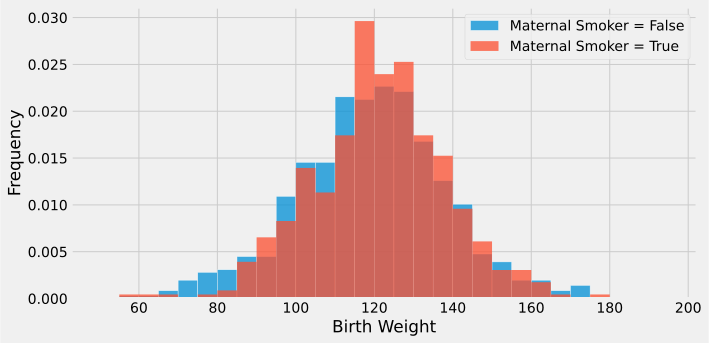

In [22]:
fig, ax = plt.subplots()
smokers = original_and_shuffled[original_and_shuffled.get('Maternal Smoker')]
non_smokers = original_and_shuffled[original_and_shuffled.get('Maternal Smoker') == False]
non_smokers.plot(kind='hist', y='shuffled', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w', figsize=(10, 5))
smokers.plot(kind='hist',y='shuffled', density=True, ax=ax, alpha=0.75, bins=baby_bins)
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight');

### How close are the means of the shuffled groups?

In [23]:
original_and_shuffled.groupby('Maternal Smoker').mean()

,Birth Weight,shuffled
Maternal Smoker,,
False,123.09,118.66
True,113.82,120.71


In [24]:
group_means = original_and_shuffled.groupby('Maternal Smoker').mean().get('shuffled')

group_means.loc[False] - group_means.loc[True]

-2.0451239392415914

- This is the test statistic for one experiment (one "shuffle").
- Let's write a function that can compute this test statistic for any shuffle.

In [25]:
def difference_in_mean_weights(weights_df):
    group_means = weights_df.groupby('Maternal Smoker').mean().get('shuffled')
    return group_means.loc[False] - group_means.loc[True]

difference_in_mean_weights(original_and_shuffled)

-2.0451239392415914

### Simulation

- This was just one random shuffle.
- How likely is it that a random shuffle results in a 9+ ounce difference in means?
- We have to repeat the shuffling a bunch of times. On each iteration:
    1. Shuffle the weights.
    2. Put them in a DataFrame.
    3. Compute the difference in group means.

### You Try: Is there a difference between smoking and non-smoking birth weights?

1. Simulate drawing a sample by shuffling the birth weights. Compute mean weight for smokers - mean weight for non-smoker.
1. Repeat Step 1 500 times. Store the results in an array called `differences`.
1. Plot the simulated differences in a histogram. Plot the observed test statistic as a vertical line.
1. Compute the p-value, and make a decision.

### Running the Simulation

In [26]:
n_repetitions = 500 # The dataset is large, so it takes too long to run if we use 5000 or 10000

differences = np.array([])
for i in np.arange(n_repetitions):
    # Step 1: Shuffle the weights
    shuffled_weights = np.random.permutation(
        smoking_and_birthweight.get('Birth Weight')
    )
    
    # Step 2: Put them in a DataFrame
    shuffled = smoking_and_birthweight.assign(
        shuffled=shuffled_weights
    )
    
    # Step 3: Compute the difference in group means and add the result to the differences array
    difference = difference_in_mean_weights(shuffled)
    
    differences = np.append(differences, difference)

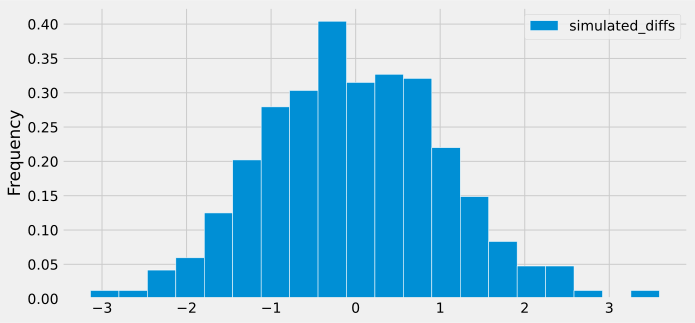

In [27]:
(bpd.DataFrame()
 .assign(simulated_diffs=differences)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);

- Note that the empirical distribution of the test statistic (difference in means) is centered around 0.
- This matches our intuition – if the null hypothesis is true, there should be no difference in the group means on average.

### Conclusion of the test

Where does our observed statistic lie?

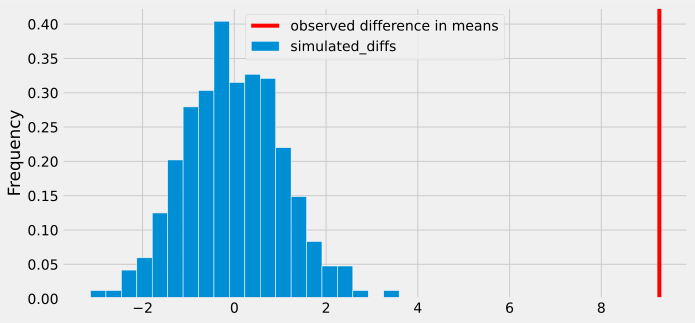

In [28]:
(bpd.DataFrame()
 .assign(simulated_diffs=differences)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(observed_difference, color='red', label='observed difference in means')
plt.legend();

In [29]:
smoker_p_value = np.count_nonzero(differences >= observed_difference) / 500
smoker_p_value

0.0

### Conclusion

- Under the null hypothesis, we rarely see differences as large as this.
- Therefore, we reject the null hypothesis: the two groups do not come from the same distribution.

### Caution! ⚠️

- We **cannot** conclude that smoking *causes* lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
- But it suggests that it may be causal.

In [30]:
show_permutation_testing_slides()

## Example 2: Deflategate 🏈

### Did the New England Patriots cheat?

<center><img width="40%" src="./data/deflate.jpg"></center>

- On January 18, 2015, the New England Patriots played the Indianapolis Colts for a spot in the Super Bowl.
- The Patriots won, 45-7. They went on to win the Super Bowl.
- After the game, it was alleged that the Patriots intentionally deflated footballs, making them easier to catch.

### Background

- Each team brings 12 footballs to the game. Teams use their own footballs while on offense.
- NFL rules stipulate that **each ball must be inflated to between 12.5 and 13.5 pounds per square inch (psi)**.
- Before the game, officials found that all of the Patriots' footballs were at about 12.5 psi, and that all of the Colts' footballs were at about 13.0 psi.
    - This pre-game data was not written down.
- In the second quarter, the Colts intercepted a Patriots ball and notified officials that it felt under-inflated.
- At halftime, two officials (Clete Blakeman and Dyrol Prioleau) independently measured the pressures of as many of the 24 footballs as they could.
    - They ran out of time before they could finish.

### The measurements

In [31]:
footballs = bpd.read_csv('data/deflategate.csv')
footballs

,Team,Blakeman,Prioleau
0,Patriots,11.50,11.80
1,Patriots,10.85,11.20
2,Patriots,11.15,11.50
...,...,...,...
12,Colts,12.75,12.30
13,Colts,12.50,12.95
14,Colts,12.55,12.15


There are only 15 rows (11 for Patriots footballs, 4 for Colts footballs) since the officials weren't able to record the pressures of every ball.

### Combining the measurements

- Both officials measured each ball.
- Their measurements are slightly different, so we'll average them to get a combined pressure for each ball.

In [32]:
footballs = footballs.assign(
    psi=(footballs.get('Blakeman') + footballs.get('Prioleau')) / 2
).drop(columns=['Blakeman', 'Prioleau'])
footballs

,Team,psi
0,Patriots,11.65
1,Patriots,11.02
2,Patriots,11.32
...,...,...
12,Colts,12.53
13,Colts,12.72
14,Colts,12.35


### Differences in average pressure

- At first glance, it looks as though the Patriots' footballs are at a lower pressure.
- We could do a permutation test for the difference in mean pressure, but that wouldn't point towards cheating.
    - The Patriot's balls *started* at a lower psi (which is not an issue on its own).
- The allegations were that the Patriots **deflated** their balls, during the game.
    - We want to check to see if the Patriots' footballs lost more pressure than the Colts' footballs from the start of the game to halftime, when these measurements were taken.

In [33]:
# Mean pressure for each team's footballs
footballs.groupby('Team').mean()

,psi
Team,
Colts,12.53
Patriots,11.30


### Calculating the pressure drop

- Let's calculate the drop in pressure for each ball in `footballs`.
- The Patriots' footballs started at around 12.5 psi, while the Colts' footballs started at around 13 psi.
- **Strategy**: we'll make an array with starting pressure for each ball, and from that subtract the halftime pressure of each ball.
    - Note that the first 11 rows correspond to Patriots balls and the last 4 rows correspond to Colts balls.
    - Thus, we need an array with 11 `12.5`s followed by 4 `13`s.
    - We can use `np.ones` to help us.

In [34]:
footballs

,Team,psi
0,Patriots,11.65
1,Patriots,11.02
2,Patriots,11.32
...,...,...
12,Colts,12.53
13,Colts,12.72
14,Colts,12.35


In [35]:
# np.ones(n) returns an array of n 1s
np.ones(11)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
starting_pressure = np.ones(11) * 12.5
starting_pressure = np.append(starting_pressure, np.ones(4) * 13)
starting_pressure

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

### Calculating the pressure drop

In [37]:
footballs = footballs.assign(
    psi_drop=(starting_pressure - footballs.get('psi'))
)
footballs

,Team,psi,psi_drop
0,Patriots,11.65,0.85
1,Patriots,11.02,1.48
2,Patriots,11.32,1.18
...,...,...,...
12,Colts,12.53,0.47
13,Colts,12.72,0.28
14,Colts,12.35,0.65


### The question

- Did the Patriots' footballs drop in pressure more than the Colts'?
    - We want to test whether two samples came from the same distribution – this calls for a permutation test.

### You Try: Permutation Test

1. State null and alternative hypotheses.
1. Pick an appropriate test statistic.
1. Simulate drawing a sample by shuffling the pressure drops. Then, calculate your test statistic on the sample.
1. Repeat step 3 5,000 times. Store your results in an array called `differences`.
1. Plot `differences` on a histogram, then plot the observed statistic as a vertical line.
1. Calculate the p-value, and draw a conclusion.

### The test statistic

Similar to in the baby weights example, our test statistic will be the difference between the teams' average pressure drops.

In [38]:
means = footballs.groupby('Team').mean().get('psi_drop')
means

Team
Colts       0.47
Patriots    1.20
Name: psi_drop, dtype: float64

In [39]:
# The observed statistic
observed_difference = means.loc['Patriots'] - means.loc['Colts']
observed_difference

0.733522727272728

The average pressure drop for the Patriots was 0.73 psi more than the Colts.

In [40]:
def difference_in_mean_pressure_drops(pressures_df):
    team_means = pressures_df.groupby('Team').mean().get('ShuffledPressureDrop')
    return team_means.loc['Patriots'] - team_means.loc['Colts']

In [41]:
n_repetitions = 5000 # The dataset is much smaller than in the baby weights example, so a larger number of repetitions will still run quickly

differences = np.array([])
for i in np.arange(n_repetitions):
    # Step 1: Shuffle the pressure drops
    shuffled_drops = np.random.permutation(footballs.get('psi_drop'))
    
    # Step 2: Put them in a DataFrame
    shuffled = footballs.assign(
        ShuffledPressureDrop=shuffled_drops
    )
    
    # Step 3: Compute the difference in group means and add the result to the differences array
    difference = difference_in_mean_pressure_drops(shuffled)

    differences = np.append(differences, difference)

### Conclusion

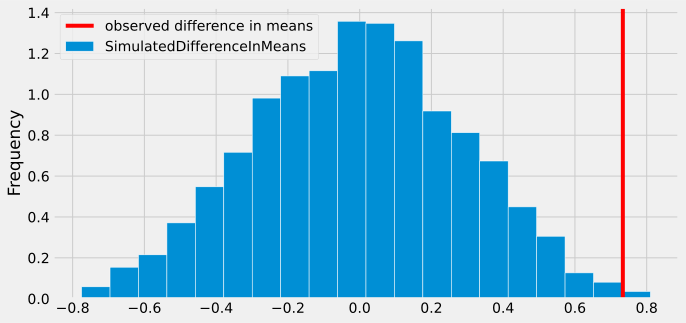

In [42]:
bpd.DataFrame().assign(SimulatedDifferenceInMeans=differences).plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
plt.axvline(observed_difference, color='red', label='observed difference in means')
plt.legend();

- It doesn't look good for the Patriots. What is the p-value?
    - Recall, the p-value is the **probability of seeing a result as or more extreme than the observation under the null hypothesis**.
    - In this case, that's the probability of the difference in mean pressure drops being greater than or equal to 0.7335.

In [43]:
observed_difference

0.733522727272728

In [44]:
# Calculating the p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.0028

This p-value is low enough to consider this result to be highly statistically significant ($p<0.01$).

### Caution! ⚠️

- We conclude that it is unlikely that the difference in mean pressure drop is due to chance alone.
- But this doesn't establish *causation*.
- That is, we can't conclude that the Patriots **intentionally** deflated their footballs.
- This was an *observational* study; to establish causation, we'd need an RCT (Randomized Controlled Trial).

### Aftermath

- Quote from an investigative report commissioned by the NFL:

> “[T]he average pressure drop of the Patriots game balls exceeded the average pressure drop of the Colts balls by 0.45 to 1.02 psi, depending on various possible assumptions regarding the gauges used, and assuming an initial pressure of 12.5 psi for the Patriots balls and 13.0 for the Colts balls.”

- Many different methods were used to determine whether the drop in pressures were due to chance, including physics. 
    - We computed an observed difference of 0.7335, which is in line with the findings of the report. 
- In the end, Tom Brady (quarterback for the Patriots at the time) was suspended 4 games and the team was fined $1 million dollars.
- The [Deflategate Wikipedia article](https://en.wikipedia.org/wiki/Deflategate) is extremely thorough, give it a read if you're curious!

## Why does it matter?

- Expanded our hypothesis testing toolbox.
- Before: test if one sample came from a known population.
- Today: test if two samples look the same.
    - And we didn't need to know the population!
- A/B testing is very, very useful.
    - Is it faster to take the bus to UCSD? Or the trolley?
    - Which button should I put on my presidential election website?
    - Many ways to do A/B test, but in DSC 10 we'll only use the permutation test.
- Next time: I have a sample of San Diego city employees. The median salary is \\$70,000.
    - But I want to estimate a range to capture uncertainty:
    - "The median city employee is between \\$60,000 and \\$80,000."